# Neural Style Transfer: Monet Paintings to Nature Photos

This project implements Neural Style Transfer (NST), a technique that combines the content of one image with the artistic style of another. Specifically, it transfers the style of Monet paintings to photos of natural scenes. The goal is to generate images that retain the structure and content of the natural photos while adopting the brushstrokes, textures, and colors characteristic of Monet's paintings.

**Dataset: Monet2Photo**

The Monet2Photo dataset is used for this project. It contains:
- 1193 Monet paintings: Artistic style images.
- 7038 natural photos: Content images.

The dataset is available on Kaggle: https://www.kaggle.com/datasets/balraj98/monet2photo

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from IPython.display import display as display_fn, Image, clear_output
from imageio import mimsave

## Loading and Preprocessing Images

- **Content Image:** A natural photo from the dataset is loaded and resized to a maximum dimension of 512 pixels to ensure uniformity and reduce computational load.
- **Style Image:** A Monet painting is loaded and resized similarly.

Both images are preprocessed to normalize pixel values and prepare them for input into the neural network.

In [14]:
# Functions for image processing and visualization
def tensor_to_image(tensor):
    """Converts a tensor to a PIL image."""
    if tf.shape(tensor).shape[0] > 3:
        tensor = tensor[0]  # Remove batch dimension if present
    return tf.keras.preprocessing.image.array_to_img(tensor)

def load_img(path, max_dim=512):
    """Loads and resizes an image to a maximum dimension."""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    scale = max_dim / max(shape)
    new_shape = tf.cast(shape * scale, tf.int32)
    
    image = tf.image.resize(image, new_shape)
    return tf.image.convert_image_dtype(image[tf.newaxis, :], tf.uint8)

def imshow(image, title=None):
    """Displays an image with an optional title."""
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    plt.axis("off")  # Turn off axis
    if title:
        plt.title(title)

def show_images(images, titles):
    """Displays a row of images with corresponding titles."""
    plt.figure(figsize=(12, 6))
    for idx, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), idx + 1)
        plt.xticks([]); plt.yticks([])
        imshow(image, title)

def clip_image_values(image, min_value=0.0, max_value=255.0):
    """Clips image pixel values to the specified range."""
    return tf.clip_by_value(image, min_value, max_value)

def preprocess_image(image):
    """Preprocesses an image for use with the Inception model."""
    return (tf.cast(image, tf.float32) / 127.5) - 1.0

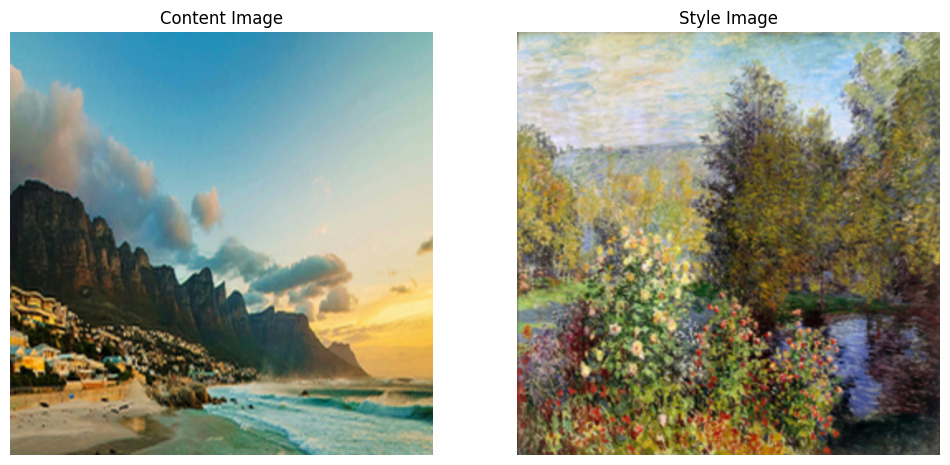

In [15]:
# Load and Display Images
content_path = 'data/trainB/2013-11-10 12_45_41.jpg'
style_path = 'data/trainA/00001.jpg'
content_image, style_image = load_img(content_path), load_img(style_path)
show_images([content_image, style_image], ['Content Image', 'Style Image'])

## Style Transfer with InceptionV3

### Feature Extraction
- A pre-trained InceptionV3 model is used to extract features from the images.
- Specific layers of the model are selected to capture:
    - **Content Features:** From deeper layers to represent the structure and content of the image.
    - **Style Features:** From earlier layers to capture textures, patterns, and colors.
- The model is frozen to prevent its weights from being updated during training.

### Loss Functions
- **Content Loss:** Measures the difference between the content features of the generated image and the original content image. This ensures the generated image retains the structure of the natural photo.
- **Style Loss:** Measures the difference between the style features (Gram matrices) of the generated image and the Monet painting. This ensures the generated image adopts the artistic style.
- **Total Loss:** A weighted combination of content and style loss, where the weights control the balance between preserving content and applying style.

In [4]:
# Build the feature extractor
K.clear_session()
content_layers = ["conv2d_88"]
style_layers = ["conv2d", "conv2d_1", "conv2d_2", "conv2d_3", "conv2d_4"]
content_and_style_layers = style_layers + content_layers

def inception_model(layer_names):
    """Creates an InceptionV3 model that outputs specified intermediate layers."""
    inception = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet")
    inception.trainable = False
    outputs = [inception.get_layer(name).output for name in layer_names]
    return tf.keras.Model(inputs=inception.input, outputs=outputs)

inception = inception_model(content_and_style_layers)

In [5]:
# Loss functions
def get_style_loss(features, targets):
    """Calculates the style loss as the mean squared error between features and targets."""
    return tf.reduce_mean(tf.square(features - targets))

def get_content_loss(features, targets):
    """Calculates the content loss as the scaled sum of squared errors."""
    return 0.5 * tf.reduce_sum(tf.square(features - targets))

def gram_matrix(input_tensor):
    """Computes the Gram matrix of the input tensor, scaled by the number of locations."""
    gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    return gram / tf.cast(tf.shape(input_tensor)[1] * tf.shape(input_tensor)[2], tf.float32)

In [6]:
# Feature extraction
def get_style_image_features(image):
    """Extracts style features (Gram matrices) from the style image."""
    preprocessed_image = preprocess_image(image)
    outputs = inception(preprocessed_image)
    return [gram_matrix(layer) for layer in outputs[:len(style_layers)]]

def get_content_image_features(image):
    """Extracts content features from the content image."""
    preprocessed_image = preprocess_image(image)
    outputs = inception(preprocessed_image)
    return outputs[len(style_layers):]

In [7]:
# Total loss calculation
def get_style_content_loss(style_targets, style_outputs, content_targets, content_outputs, style_weight, content_weight):
    """Combines style and content loss into a total loss."""
    style_loss = tf.add_n([get_style_loss(style_output, target) for style_output, target in zip(style_outputs, style_targets)])
    content_loss = tf.add_n([get_content_loss(content_output, target) for content_output, target in zip(content_outputs, content_targets)])
    return (style_weight * style_loss / len(style_layers)) + (content_weight * content_loss / len(content_layers))

In [8]:
# Gradient calculation and image update
def calculate_gradients(image, style_targets, content_targets, style_weight, content_weight):
    """Calculates gradients of the total loss with respect to the image."""
    with tf.GradientTape() as tape:
        style_features = get_style_image_features(image)
        content_features = get_content_image_features(image)
        loss = get_style_content_loss(style_targets, style_features, content_targets, content_features, style_weight, content_weight)
    return tape.gradient(loss, image)

def update_image_with_style(image, style_targets, content_targets, style_weight, content_weight, optimizer):
    """Updates the image using the calculated gradients."""
    gradients = calculate_gradients(image, style_targets, content_targets, style_weight, content_weight)
    optimizer.apply_gradients([(gradients, image)])
    image.assign(clip_image_values(image))

### Optimization
- The Adam optimizer is used to minimize the total loss.
- The learning rate is dynamically adjusted using an exponential decay schedule to ensure stable convergence.
- Gradients of the loss with respect to the generated image are computed and applied iteratively to update the image.

### Image Generation
- The process is repeated for a specified number of **epochs** and **steps per epoch**.
- During training:
    - Progress is indicated by printing dots (.) for each step.
    - The current stylized image is displayed at the end of each epoch to visualize the transformation.
- The final output is a stylized image that combines the content of the natural photo with the artistic style of the Monet painting.

In [9]:
# Style transfer function
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4, optimizer='adam', epochs=1, steps_per_epoch=1):
    """Performs neural style transfer and displays progress."""
    style_targets = get_style_image_features(style_image)
    content_targets = get_content_image_features(content_image)
    generated_image = tf.Variable(tf.cast(content_image, tf.float32))
    images = [content_image]

    for epoch in range(epochs):
        for step in range(steps_per_epoch):
            update_image_with_style(generated_image, style_targets, content_targets, style_weight, content_weight, optimizer)
            print(".", end='')  # Print progress dots
            if (step + 1) % 10 == 0:
                images.append(generated_image)
        
        clear_output(wait=True)  # Clear output to display the latest image
        display_image = tensor_to_image(generated_image)
        display_fn(display_image)  # Display the current stylized image
        images.append(generated_image)
        print(f"Epoch {epoch + 1}, Step {step + 1}")

    return tf.cast(generated_image, tf.uint8), images

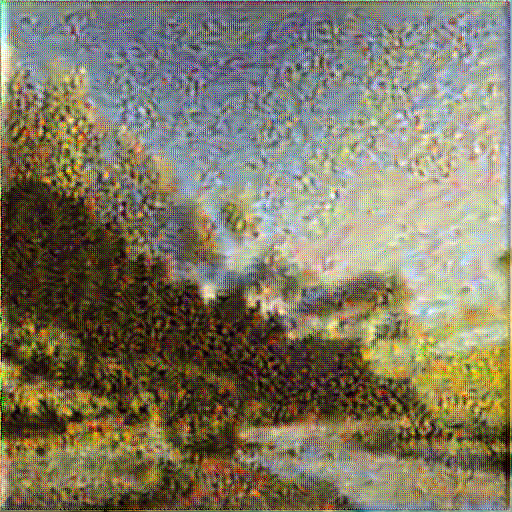

Epoch 10, Step 100


In [10]:
# Run style transfer
style_weight, content_weight = 1, 1e-32
adam = tf.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=80.0, decay_steps=100, decay_rate=0.80))
stylized_image, display_images = fit_style_transfer(style_image, content_image, style_weight, content_weight, adam, epochs=10, steps_per_epoch=100)

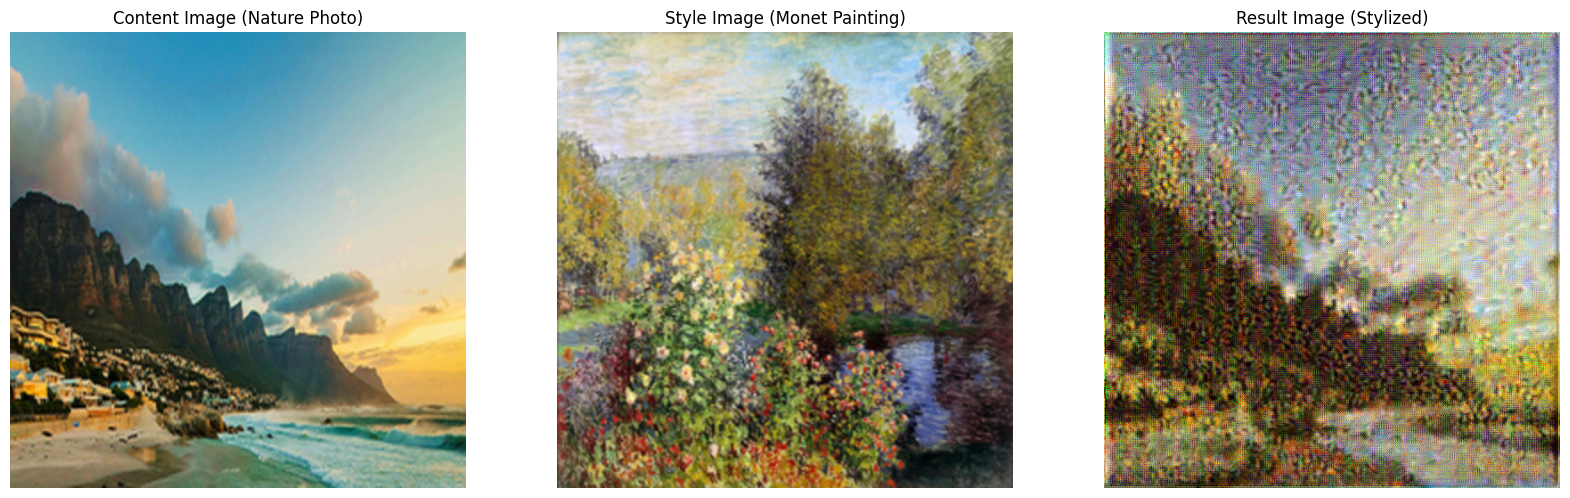

In [13]:
# Visualize the input and output of the neural style transfer
def display_images(content_image, style_image, result_image):
    """Displays the content, style, and result images side by side."""
    plt.figure(figsize=(20, 6))

    # Display the content image (nature photo)
    plt.subplot(1, 3, 1)
    plt.imshow(content_image[0] if len(content_image.shape) > 3 else content_image)
    plt.title("Content Image (Nature Photo)")
    plt.axis("off")

    # Display the style image (Monet painting)
    plt.subplot(1, 3, 2)
    plt.imshow(style_image[0] if len(style_image.shape) > 3 else style_image)
    plt.title("Style Image (Monet Painting)")
    plt.axis("off")

    # Display the result image (stylized image)
    plt.subplot(1, 3, 3)
    plt.imshow(result_image[0] if len(result_image.shape) > 3 else result_image)
    plt.title("Result Image (Stylized)")
    plt.axis("off")

    plt.show()

display_images(content_image, style_image, stylized_image)

## Results
The final stylized image is generated, incorporating Monet’s artistic style into the natural landscape while preserving its structure. This project showcases the power of deep learning in blending art and technology, enabling the creation of stunning visual transformations.

*This project was implemented using the **Generative Deep Learning with TensorFlow** course by DeepLearning.AI as a foundational guide: https://www.coursera.org/learn/generative-deep-learning-with-tensorflow/*